In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as opt
from scipy.optimize import minimize
import pandas as pd
import os.path as path
import os
import wget
from tqdm import tqdm

<h1>PARTE 1

In [2]:
if not path.exists('Data'):
    os.mkdir('Data')
    
file = 'Data/Interpolacion.dat'
url="https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/DataRotacion.csv"

if not path.exists(file):
    Path_ = wget.download(url,file)
    
else:
    Path_ = file
Data = pd.read_csv(Path_)

In [3]:
lamd30=Data[Data.angle == 30.0]
lamd30

,h,angle,y,sigmay
20,10.0,30.0,0.0013,0.0015
21,20.0,30.0,0.0017,0.0015
22,30.0,30.0,0.0038,0.0015
23,40.0,30.0,0.0059,0.0015
24,50.0,30.0,0.0067,0.0015
25,60.0,30.0,0.0094,0.0015
26,70.0,30.0,0.0122,0.0015
27,80.0,30.0,0.0132,0.0015
28,90.0,30.0,0.0151,0.0015
29,100.0,30.0,0.0186,0.0015


In [4]:
def modelo(h,w=2*np.pi/(24*60*60)):
    lamda=np.pi/180*30
    g=9.81
    a=2*np.sqrt(2)/3
    y=a*w*np.cos(lamda)*np.sqrt(h**3/g)
    return y

In [5]:
r=lamd30.y - modelo(lamd30.h)
chisq=sum((r/lamd30.sigmay)**2)

In [6]:
param,inc2=opt(modelo,lamd30.h,lamd30.y,sigma=np.full_like(lamd30.h,chisq))

In [7]:
print("magnitud de w")
print(param[0])
print("")
print("inc del w según el ajuste")
print(np.sqrt(inc2[0][0]))

magnitud de w
7.244743100545753e-05

inc del w según el ajuste
1.6693247983736118e-06


In [8]:
y=modelo(lamd30.h,param[0])

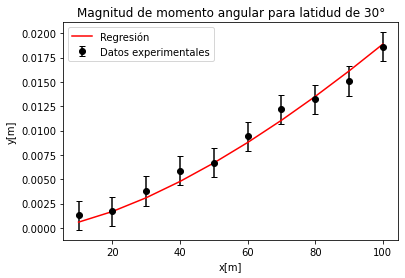

In [9]:
plt.errorbar(lamd30.h,lamd30.y,yerr=lamd30.sigmay,fmt='ko',label="Datos experimentales",capsize=3)
plt.plot(lamd30.h,y,color='r',label="Regresión")
plt.ylabel("y[m]")
plt.xlabel("x[m]")
plt.title("Magnitud de momento angular para latidud de 30°")
plt.legend()

<h1>PARTE 2

In [10]:
N=300
Gravedad=np.zeros(N)
ys=np.zeros(N,dtype=object)

In [11]:
for i in range(N):
    Gravedad[i] =9.81+ np.random.normal(loc=1,scale=1)
    y=lamd30.y+np.random.normal(loc=0,scale=np.array(lamd30.sigmay)[0],size=len(lamd30.y))
    ys[i]=y

In [12]:
x=lamd30.h

In [13]:
class modelodepg:
    def __init__(self,g,lamda):
        self.g=g
        self.lamda=lamda
    
    def modelo(self,h,w=2*np.pi/(24*60*60)):
        lamda=np.pi/180*self.lamda
        g=self.g
        a=2*np.sqrt(2)/3
        y=a*w*np.cos(lamda)*np.sqrt(h**3/g)
        return y

In [14]:
listparam=[]
for i in tqdm(range(len(Gravedad))):
    obj=modelodepg(Gravedad[i],lamd30.angle)
    r=ys[i]-obj.modelo(x)
    chisq=sum((r/lamd30.sigmay)**2)
    param,inc2=opt(obj.modelo,x,ys[i],sigma=np.full_like(x,chisq))
    listparam.append(param)
listparam=np.array(listparam)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 106.35it/s]


In [15]:
Omega=listparam[:,0]

In [16]:
H2,binsx,binsy = np.histogram2d(Omega,Gravedad,bins=(25,25))

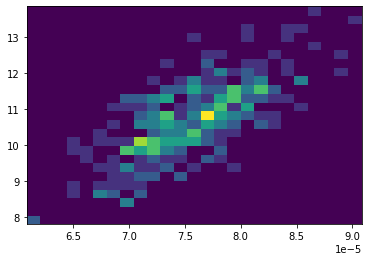

In [17]:
_=plt.hist2d(Omega,Gravedad,bins=(binsx,binsy))

Las variables parecen tener una correlación algo similar a una normal en la diagonal

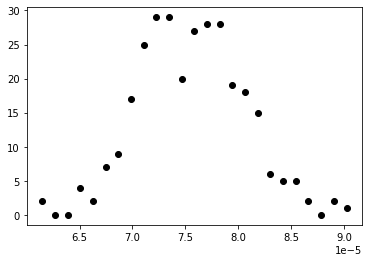

In [18]:
nbinsx=[]
nbinsy=[]
for i in range(len(binsx)-1):
    nbinsx.append((binsx[i]+binsx[i+1])/2)
    nbinsy.append((binsy[i]+binsy[i+1])/2)
nbinsx=np.array(nbinsx)
nbinsy=np.array(nbinsy)
H1 = np.sum(H2,axis=1)
x=np.linspace(min(nbinsx),max(nbinsx),len(nbinsx))
plt.scatter(x,H1,color='k')

In [19]:
cs = np.cumsum(H1)
ij = np.searchsorted(cs,np.percentile(cs,16))
ii = np.searchsorted(cs,np.percentile(cs,50))
ji = np.searchsorted(cs,np.percentile(cs,84))

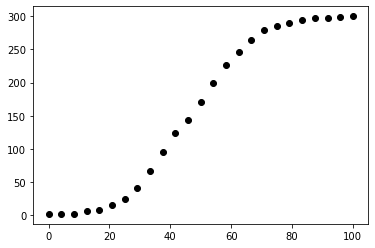

In [20]:
x=np.linspace(0,100,len(cs))
plt.scatter(x,cs,color='k')

Efectivamente, parece una normal. Con media en el precentil 50 y varianza de calculable con las diferencias entre el percentil 16 y 84 dividido en 2

In [21]:
mu=nbinsx[ii]
sigma=(nbinsx[ji]-nbinsx[ij])/2

In [22]:
print("El w para lambda 30 es aproximadamente:")
print(mu)
print("El sigma para lambda 30 es aproximadamente:")
print(sigma)

El w para lambda 30 es aproximadamente:
7.585087823110904e-05
El sigma para lambda 30 es aproximadamente:
1.0191418161024034e-05


<h1>Parte 3

In [23]:
a=[10.0,20.0,40.0,50.0,60.0]
lambdas=[]
for i in a:
    lambdas.append(Data[Data.angle==i])
lambdas.append(Data)

In [24]:
Res=[]
for i in a:
    Res.append([i])
Res.append(["Todos"])

In [25]:
def round_to_3(x):
    return round(x, -int(np.math.floor(np.math.log10(abs(x))))+2)

In [26]:
count=0
mus=[]
sigmas=[]
siv=[]
for k in tqdm(lambdas):
    
    N=300
    Gravedad=np.zeros(N)
    ys=np.zeros(N,dtype=object)
    for i in range(N):
        Gravedad[i] =9.81+ np.random.normal(loc=1,scale=1)
        y=k.y+np.random.normal(loc=0,scale=np.array(k.sigmay)[0],size=len(k.y))
        ys[i]=y
    x=k.h
    
    listparam=[]
    for i in range(len(Gravedad)):
        obj=modelodepg(Gravedad[i],k.angle)
        r=ys[i]-obj.modelo(x)
        chisq=sum((r/k.sigmay)**2)
        param,_=opt(obj.modelo,x,ys[i],sigma=np.full_like(x,chisq))
        listparam.append(param)
    listparam=np.array(listparam)
    
    Omega=listparam[:,0]
    
    H2,binsx,binsy = np.histogram2d(Omega,Gravedad,bins=(25,25))
    nbinsx=[]
    nbinsy=[]
    for i in range(len(binsx)-1):
        nbinsx.append((binsx[i]+binsx[i+1])/2)
        nbinsy.append((binsy[i]+binsy[i+1])/2)

    H1 = np.sum(H2,axis=1)
    cs = np.cumsum(H1)
    ij = np.searchsorted(cs,np.percentile(cs,16))
    ii = np.searchsorted(cs,np.percentile(cs,50))
    ji = np.searchsorted(cs,np.percentile(cs,84))
    
    mu=nbinsx[ii]
    sigma=(nbinsx[ji]-nbinsx[ij])/2
    
    Res[count].append(round_to_3(mu))
    Res[count].append(round_to_3(sigma))
    Res[count].append(round_to_3(sigma/mu))
    count+=1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.87s/it]


In [33]:
print("Lamb.  w        sigma     sigma/w")
for i in Res:
    print(i)

Lamb.  w        sigma     sigma/w
[10.0, 7.7e-05, 9.14e-06, 0.119]
[20.0, 7.61e-05, 9.8e-06, 0.129]
[40.0, 7.83e-05, 9.74e-06, 0.124]
[50.0, 7.18e-05, 1.19e-05, 0.165]
[60.0, 7.98e-05, 1.34e-05, 0.168]
['Todos', 7.69e-05, 8.43e-06, 0.11]


Se evidencia una menor relación error/valor cuando se toman en cuenta

In [36]:
x=[]
y=[]
erry=[]
for i in Res:
    x.append(str(i[0]))
    y.append(i[1])
    erry.append(i[2])

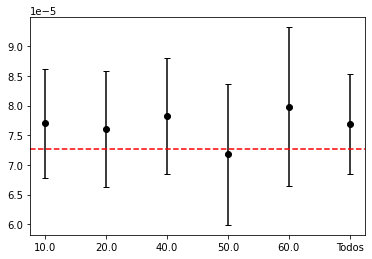

In [41]:
plt.errorbar(x,y,yerr=erry,fmt='ko',label="Datos experimentales",capsize=3)
plt.axhline(y = 7.27*10**-5, color = 'r', linestyle = '--')
plt.ylabel("w[Rads/s]")
plt.xlabel("Lambdas")
plt.title("Comparación de resultados experimentales")